---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
title: User Specified Basic Lightning Module With spotpython
jupyter: python3
---

## Introduction

This chapter implements a user-defined DataModule and a user-defined neural network.
Remember, that a `LightningModule` organizes your `PyTorch` code into six sections:

* Initialization (`__init__` and `setup()`).
* Train Loop (`training_step()`)
* Validation Loop (`validation_step()`)
* Test Loop (`test_step()`)
* Prediction Loop (`predict_step()`)
* Optimizers and LR Schedulers (`configure_optimizers()`)

The `Trainer` automates every required step in a clear and reproducible way. It is the most important part of PyTorch Lightning. It is responsible for training, testing, and validating the model.
The `Lightning` core structure looks like this:

In [1]:
import pandas as pd
df = pd.read_pickle("./userData/Turbo_Charger_Data.pkl")
df = df.drop(columns=["M", "R"])
print(f"Features des DataFrames: {df.columns}")
print(df.shape)

Features des DataFrames: Index(['N', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'W', 'X', 'Y', 'AS',
       'AT', 'AV', 'AW', 'AX', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BF', 'BG', 'BH',
       'BI', 'BJ', 'BL', 'BM', 'BN', 'BP', 'BQ', 'BR', 'BS', 'BU', 'BV', 'BW',
       'BX', 'BY', 'BZ', 'CA', 'CB', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK',
       'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW',
       'CX', 'CY', 'CZ', 'DA', 'DB', 'DC', 'DD', 'DE', 'DG', 'DH', 'DI', 'DJ',
       'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DU', 'DV'],
      dtype='object')
(20185, 85)


### Dataset

In [2]:
from sklearn.preprocessing import LabelEncoder
from lightning import LightningDataModule
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class UserDataset(Dataset):
    def __init__(self, data, y_varname="N", x_varnames=None, dtype=torch.float32):
        """
        Args:
            data (pd.DataFrame):
                The user data. for example,
                generated by the `preprocess_data` function.
            y_varname (str):
                The name of the target variable.
                Default is "N".
            x_varnames (list):
                The names of the input variables.
                Default is `None`, which means all columns
                except the target variable are used.
            dtype (torch.dtype):
                The data type for the tensors.
                Default is `torch.float32`.

        Examples:
            >>> dataset = UserDataset(data)
            >>> x, y = dataset[0]
        """
        self.data = data.reset_index(drop=True)
        if x_varnames is not None:
            self.x_varnames = x_varnames
        else:
            self.x_varnames = [col for col in self.data.columns if col != y_varname]
        print(f"X variables: {self.x_varnames}")
        print(f"Y variable: {y_varname}")
        self.y_varname = y_varname
        self.dtype = dtype
        self.encoders = {}

        for var in self.x_varnames:
            if self.data[var].dtype == "object" or isinstance(self.data[var][0], str):
                le = LabelEncoder()
                self.data[var] = le.fit_transform(self.data[var])
                self.encoders[var] = le

        if self.data[self.y_varname].dtype == "object" or isinstance(self.data[self.y_varname][0], str):
            le = LabelEncoder()
            self.data[self.y_varname] = le.fit_transform(self.data[self.y_varname])
            self.encoders[self.y_varname] = le

        # Convert entire dataset to tensors
        self.features = torch.tensor(self.data[self.x_varnames].values, dtype=self.dtype)
        self.targets = torch.tensor(self.data[self.y_varname].values, dtype=self.dtype)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [3]:
dataset = UserDataset(df)
x, y = dataset[0]
print(x)
print(y)

X variables: ['C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'W', 'X', 'Y', 'AS', 'AT', 'AV', 'AW', 'AX', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BL', 'BM', 'BN', 'BP', 'BQ', 'BR', 'BS', 'BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'DA', 'DB', 'DC', 'DD', 'DE', 'DG', 'DH', 'DI', 'DJ', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DU', 'DV']
Y variable: N
tensor([0.0000e+00, 3.0600e-01, 0.0000e+00, 1.7872e+02, 3.4066e+04, 1.1000e+01,
        6.2344e+03, 2.0000e+00, 6.0000e+00, 1.6100e+00, 8.9000e-01, 0.0000e+00,
        1.0776e+01, 4.0401e+01, 3.4102e+04, 5.1424e+02, 1.2988e+03, 9.6207e-01,
        9.6220e-01, 7.9336e-01, 3.7692e+00, 4.7509e+00, 2.8016e+00, 2.8023e+00,
        4.9809e-02, 5.0379e-02, 2.3957e+02, 3.1711e+00, 3.6794e+00, 5.3055e-01,
        9.1941e-01, 2.5377e+00, 4.6485e+01, 2.4010e+01, 2.4941e+01, 2.4836e+01,


### DataModule

In [4]:
import lightning as L
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from typing import Optional
from math import floor


class LightDataModule(L.LightningDataModule):
    """
    A LightningDataModule for handling data.

    Args:
        batch_size (int):
            The batch size. Required.
        dataset (torch.utils.data.Dataset, optional):
            The dataset from the torch.utils.data Dataset class.
            It must implement three functions: __init__, __len__, and __getitem__.
        test_size (float, optional):
            The test size. If test_size is float, then train_size is 1 - test_size.
            If test_size is int, then train_size is len(data_full) - test_size.
        test_seed (int):
            The test seed. Defaults to 42.
        num_workers (int):
            The number of workers. Defaults to 0.
        verbosity (int):
            The verbosity level. Defaults to 0.

    Examples:
        >>> from spotpython.data.lightdatamodule import LightDataModule
            from spotpython.data.csvdataset import CSVDataset
            from spotpython.utils.scaler import TorchStandardScaler
            import torch
            # data.csv is simple csv file with 11 samples
            dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
            scaler = TorchStandardScaler()
            data_module = LightDataModule(dataset=dataset, batch_size=5, test_size=0.5, scaler=scaler)
            data_module.setup()
            print(f"Training set size: {len(data_module.data_train)}")
            print(f"Validation set size: {len(data_module.data_val)}")
            print(f"Test set size: {len(data_module.data_test)}")
            full_train_size: 0.5
            val_size: 0.25
            train_size: 0.25
            test_size: 0.5
            Training set size: 3
            Validation set size: 3
            Test set size: 6

    References:
        See https://lightning.ai/docs/pytorch/stable/data/datamodule.html

    """

    def __init__(
        self,
        batch_size: int,
        dataset: Optional[object] = None,
        test_size: Optional[float] = None,
        test_seed: int = 42,
        num_workers: int = 0,
        verbosity: int = 0,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.data_full = dataset
        self.test_size = test_size
        self.test_seed = test_seed
        self.num_workers = num_workers
        self.verbosity = verbosity

    def prepare_data(self) -> None:
        """Prepares the data for use."""
        # download
        pass

    def _setup_full_data_provided(self, stage) -> None:
        full_size = len(self.data_full)
        test_size = self.test_size

        # consider the case when test_size is a float
        if isinstance(self.test_size, float):
            full_train_size = 1.0 - self.test_size
            val_size = full_train_size * self.test_size
            train_size = full_train_size - val_size
        else:
            # test_size is an int, training size calculation directly based on it
            full_train_size = full_size - self.test_size
            val_size = floor(full_train_size * self.test_size / full_size)
            train_size = full_size - val_size - test_size

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            generator_fit = torch.Generator().manual_seed(self.test_seed)
            self.data_train, self.data_val, _ = random_split(self.data_full, [train_size, val_size, test_size], generator=generator_fit)
            if self.verbosity > 0:
                print(f"train_size: {train_size}, val_size: {val_size}, test_sie: {test_size} for splitting train & val data.")
                print(f"train samples: {len(self.data_train)}, val samples: {len(self.data_val)} generated for train & val data.")

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            generator_test = torch.Generator().manual_seed(self.test_seed)
            self.data_test, _, _ = random_split(self.data_full, [test_size, train_size, val_size], generator=generator_test)
            if self.verbosity > 0:
                print(f"train_size: {train_size}, val_size: {val_size}, test_sie: {test_size} for splitting test data.")
                print(f"test samples: {len(self.data_test)} generated for test data.")

        # Assign pred dataset for use in dataloader(s)
        if stage == "predict" or stage is None:
            generator_predict = torch.Generator().manual_seed(self.test_seed)
            self.data_predict, _, _ = random_split(self.data_full, [test_size, train_size, val_size], generator=generator_predict)
            if self.verbosity > 0:
                print(f"train_size: {train_size}, val_size: {val_size}, test_size (= predict_size): {test_size} for splitting predict data.")
                print(f"predict samples: {len(self.data_predict)} generated for train & val data.")
    

    def setup(self, stage: Optional[str] = None) -> None:
        """
        Splits the data for use in training, validation, and testing.
        Uses torch.utils.data.random_split() to split the data.
        Splitting is based on the test_size and test_seed.
        The test_size can be a float or an int.
        If a spotpython scaler object is defined, the data will be scaled.

        Args:
            stage (Optional[str]):
                The current stage. Can be "fit" (for training and validation), "test" (testing),
                or None (for all three stages). Defaults to None.

        Examples:
            >>> from spotpython.data.lightdatamodule import LightDataModule
                from spotpython.data.csvdataset import CSVDataset
                import torch
                dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
                data_module = LightDataModule(dataset=dataset, batch_size=5, test_size=0.5)
                data_module.setup()
                print(f"Training set size: {len(data_module.data_train)}")
                Training set size: 3

        """
        self._setup_full_data_provided(stage)


    def train_dataloader(self) -> DataLoader:
        """
        Returns the training dataloader, i.e., a pytorch DataLoader instance
        using the training dataset.

        Returns:
            DataLoader: The training dataloader.

        Examples:
            >>> from spotpython.data.lightdatamodule import LightDataModule
                from spotpython.data.csvdataset import CSVDataset
                import torch
                dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
                data_module = LightDataModule(dataset=dataset, batch_size=5, test_size=0.5)
                data_module.setup()
                print(f"Training set size: {len(data_module.data_train)}")
                Training set size: 3

        """
        if self.verbosity > 0:
            print(f"LightDataModule.train_dataloader(). data_train size: {len(self.data_train)}")
        return DataLoader(self.data_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self) -> DataLoader:
        """
        Returns the validation dataloader, i.e., a pytorch DataLoader instance
        using the validation dataset.

        Returns:
            DataLoader: The validation dataloader.

        Examples:
            >>> from spotpython.data.lightdatamodule import LightDataModule
                from spotpython.data.csvdataset import CSVDataset
                import torch
                dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
                data_module = LightDataModule(dataset=dataset, batch_size=5, test_size=0.5)
                data_module.setup()
                print(f"Training set size: {len(data_module.data_val)}")
                Training set size: 3
        """
        if self.verbosity > 0:
            print(f"LightDataModule.val_dataloader(). Val. set size: {len(self.data_val)}")
        return DataLoader(self.data_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        """
        Returns the test dataloader, i.e., a pytorch DataLoader instance
        using the test dataset.

        Returns:
            DataLoader: The test dataloader.

        Examples:
            >>> from spotpython.data.lightdatamodule import LightDataModule
                from spotpython.data.csvdataset import CSVDataset
                import torch
                dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
                data_module = LightDataModule(dataset=dataset, batch_size=5, test_size=0.5)
                data_module.setup()
                print(f"Test set size: {len(data_module.data_test)}")
                Test set size: 6

        """
        if self.verbosity > 0:
            print(f"LightDataModule.test_dataloader(). Test set size: {len(self.data_test)}")
        return DataLoader(self.data_test, batch_size=self.batch_size, num_workers=self.num_workers)

    def predict_dataloader(self) -> DataLoader:
        """
        Returns the predict dataloader, i.e., a pytorch DataLoader instance
        using the predict dataset.

        Returns:
            DataLoader: The predict dataloader.

        Examples:
            >>> from spotpython.data.lightdatamodule import LightDataModule
                from spotpython.data.csvdataset import CSVDataset
                import torch
                dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
                data_module = LightDataModule(dataset=dataset, batch_size=5, test_size=0.5)
                data_module.setup()
                print(f"Predict set size: {len(data_module.data_predict)}")
                Predict set size: 6

        """
        if self.verbosity > 0:
            print(f"LightDataModule.predict_dataloader(). Predict set size: {len(self.data_predict)}")
        return DataLoader(self.data_predict, batch_size=len(self.data_predict), num_workers=self.num_workers)

In [5]:
data_module = LightDataModule(batch_size=2, dataset=dataset, test_size=0.2)
data_module.setup()
for batch in data_module.train_dataloader():
    print(batch)
    print(f"Number of input features: {batch[0][1].shape}")
    break

[tensor([[2.2000e+01, 3.0600e-01, 3.0000e+00, 3.1520e+01, 3.7315e+04, 1.5000e+01,
         9.3302e+03, 3.0000e+00, 1.0000e+01, 1.8800e+00, 9.3000e-01, 0.0000e+00,
         1.2837e+01, 4.0209e+01, 3.7370e+04, 5.6352e+02, 1.4195e+03, 9.6041e-01,
         9.6059e-01, 7.0362e-01, 4.0244e+00, 5.7195e+00, 3.0372e+00, 3.0367e+00,
         7.7444e-02, 7.7738e-02, 2.5032e+02, 4.5492e+00, 5.2783e+00, 5.1146e-01,
         8.0917e-01, 2.5863e+00, 6.1389e+01, 2.4728e+01, 2.6248e+01, 2.6221e+01,
         2.6692e+01, 2.7086e+01, 2.7137e+01, 2.7063e+01, 2.6286e+01, 2.7149e+01,
         2.6441e+02, 2.6456e+02, 2.6022e+02, 2.6437e+02, 2.6395e+02, 2.6031e+02,
         9.5069e-01, 1.1560e+00, 1.1550e+00, 1.1508e+00, 1.0407e+00, 1.1536e+00,
         1.1524e+00, 1.1450e+00, 1.1487e+00, 1.0314e+00, 9.7338e-01, 9.4253e-01,
         1.0277e+00, 9.7142e-01, 9.4353e-01, 1.0185e+00, 9.6827e-01, 9.4402e-01,
         1.0204e+00, 9.7001e-01, 9.4271e-01, 1.6898e+00, 1.5291e+00, 1.9055e+00,
         4.1508e+01, 4.9909

## The Neural Network: MyRegressor

In [6]:
#| label: MyRegressor
#| eval: false
import lightning as L
import torch
from torch import nn
from spotpython.hyperparameters.optimizer import optimizer_handler
import torchmetrics.functional.regression
from math import ceil

class MyRegressor(L.LightningModule):
    """
    A LightningModule class for a regression neural network model.

    Attributes:
        l1 (int):
            The number of neurons in the first hidden layer.
        epochs (int):
            The number of epochs to train the model for.
        batch_size (int):
            The batch size to use during training.
        initialization (str):
            The initialization method to use for the weights.
        act_fn (nn.Module):
            The activation function to use in the hidden layers.
        optimizer (str):
            The optimizer to use during training.
        dropout_prob (float):
            The probability of dropping out a neuron during training.
        lr_mult (float):
            The learning rate multiplier for the optimizer.
        patience (int):
            The number of epochs to wait before early stopping.
        _L_in (int):
            The number of input features.
        _L_out (int):
            The number of output classes.
        _torchmetric (str):
            The metric to use for the loss function. If `None`,
            then "mean_squared_error" is used.
        layers (nn.Sequential):
            The neural network model.

    """

    def __init__(
        self,
        l1: int,
        epochs: int,
        batch_size: int,
        initialization: str,
        act_fn: nn.Module,
        optimizer: str,
        dropout_prob: float,
        lr_mult: float,
        patience: int,
        _L_in: int,
        _L_out: int,
        _torchmetric: str,
        *args,
        **kwargs,
    ):
        """
        Initializes the MyRegressor object.

        Args:
            l1 (int):
                The number of neurons in the first hidden layer.
            epochs (int):
                The number of epochs to train the model for.
            batch_size (int):
                The batch size to use during training.
            initialization (str):
                The initialization method to use for the weights.
            act_fn (nn.Module):
                The activation function to use in the hidden layers.
            optimizer (str):
                The optimizer to use during training.
            dropout_prob (float):
                The probability of dropping out a neuron during training.
            lr_mult (float):
                The learning rate multiplier for the optimizer.
            patience (int):
                The number of epochs to wait before early stopping.
            _L_in (int):
                The number of input features. Not a hyperparameter, but needed to create the network.
            _L_out (int):
                The number of output classes. Not a hyperparameter, but needed to create the network.
            _torchmetric (str):
                The metric to use for the loss function. If `None`,
                then "mean_squared_error" is used.

        Returns:
            (NoneType): None

        Raises:
            ValueError: If l1 is less than 4.

        """
        super().__init__()
        self._L_in = _L_in
        self._L_out = _L_out
        if _torchmetric is None:
            _torchmetric = "mean_squared_error"
        self._torchmetric = _torchmetric
        self.metric = getattr(torchmetrics.functional.regression, _torchmetric)
        # _L_in and _L_out are not hyperparameters, but are needed to create the network
        # _torchmetric is not a hyperparameter, but is needed to calculate the loss
        self.save_hyperparameters(ignore=["_L_in", "_L_out", "_torchmetric"])
        # set dummy input array for Tensorboard Graphs
        # set log_graph=True in Trainer to see the graph (in traintest.py)
        self.example_input_array = torch.zeros((batch_size, self._L_in))
        if self.hparams.l1 < 4:
            raise ValueError("l1 must be at least 4")
        hidden_sizes = [l1 * 2, l1, ceil(l1/2)]
        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [self._L_in] + hidden_sizes
        layer_size_last = layer_sizes[0]
        for layer_size in layer_sizes[1:]:
            layers += [
                nn.Linear(layer_size_last, layer_size),
                self.hparams.act_fn,
                nn.Dropout(self.hparams.dropout_prob),
            ]
            layer_size_last = layer_size
        layers += [nn.Linear(layer_sizes[-1], self._L_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the model.

        Args:
            x (torch.Tensor): A tensor containing a batch of input data.

        Returns:
            torch.Tensor: A tensor containing the output of the model.

        """
        x = self.layers(x)
        return x

    def _calculate_loss(self, batch):
        """
        Calculate the loss for the given batch.

        Args:
            batch (tuple): A tuple containing a batch of input data and labels.

        Returns:
            torch.Tensor: A tensor containing the loss for this batch.

        """
        x, y = batch
        y = y.view(len(y), 1)
        y_hat = self(x)
        loss = self.metric(y_hat, y)
        return loss

    def training_step(self, batch: tuple) -> torch.Tensor:
        """
        Performs a single training step.

        Args:
            batch (tuple): A tuple containing a batch of input data and labels.

        Returns:
            torch.Tensor: A tensor containing the loss for this batch.

        """
        val_loss = self._calculate_loss(batch)
        return val_loss

    def validation_step(self, batch: tuple, batch_idx: int, prog_bar: bool = False) -> torch.Tensor:
        """
        Performs a single validation step.

        Args:
            batch (tuple): A tuple containing a batch of input data and labels.
            batch_idx (int): The index of the current batch.
            prog_bar (bool, optional): Whether to display the progress bar. Defaults to False.

        Returns:
            torch.Tensor: A tensor containing the loss for this batch.

        """
        val_loss = self._calculate_loss(batch)
        self.log("val_loss", val_loss, prog_bar=prog_bar)
        self.log("hp_metric", val_loss, prog_bar=prog_bar)
        return val_loss

    def test_step(self, batch: tuple, batch_idx: int, prog_bar: bool = False) -> torch.Tensor:
        """
        Performs a single test step.

        Args:
            batch (tuple): A tuple containing a batch of input data and labels.
            batch_idx (int): The index of the current batch.
            prog_bar (bool, optional): Whether to display the progress bar. Defaults to False.

        Returns:
            torch.Tensor: A tensor containing the loss for this batch.
        """
        val_loss = self._calculate_loss(batch)
        self.log("val_loss", val_loss, prog_bar=prog_bar)
        self.log("hp_metric", val_loss, prog_bar=prog_bar)
        return val_loss

    def predict_step(self, batch: tuple, batch_idx: int, prog_bar: bool = False) -> torch.Tensor:
        """
        Performs a single prediction step.

        Args:
            batch (tuple): A tuple containing a batch of input data and labels.
            batch_idx (int): The index of the current batch.
            prog_bar (bool, optional): Whether to display the progress bar. Defaults to False.

        Returns:
            A tuple containing the input data, the true labels, and the predicted values.
        """
        x, y = batch
        yhat = self(x)
        y = y.view(len(y), 1)
        yhat = yhat.view(len(yhat), 1)
        print(f"Predict step x: {x}")
        print(f"Predict step y: {y}")
        print(f"Predict step y_hat: {yhat}")
        return (x, y, yhat)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimizer for the model.
        Simple examples use the following code here:
        `optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)`

        Notes:
            The default Lightning way is to define an optimizer as
            `optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)`.
            spotpython uses an optimizer handler to create the optimizer, which
            adapts the learning rate according to the lr_mult hyperparameter as
            well as other hyperparameters. See `spotpython.hyperparameters.optimizer.py` for details.

        Returns:
            torch.optim.Optimizer: The optimizer to use during training.

        """
        # optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        optimizer = optimizer_handler(
            optimizer_name=self.hparams.optimizer, params=self.parameters(), lr_mult=self.hparams.lr_mult
        )
        return optimizer

## Calling the Neural Network With spotpython

In [7]:
#| label: prefix_setup
PREFIX="my_lightning_user_datamodule"

In [8]:
#| label: spotpython_setup
import sys
sys.path.insert(0, './userModel')
import my_regressor
import my_hyper_dict

In [9]:
from spotpython.hyperparameters.values import add_core_model_to_fun_control
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.spot import spot
from math import inf
fun_control = fun_control_init(
    PREFIX=PREFIX,
    fun_evals=inf,
    fun_repeats=1,
    max_time=5,
    accelerator="cpu",
    data_module=data_module,
    _L_in=dataset[0][0].shape[0],
    _L_out=1,
    noise=False,
    ocba_delta=0,
    TENSORBOARD_CLEAN=True,
    tensorboard_log=True,
    _torchmetric="mean_squared_error",
    log_level=50,
    save_experiment=True,
    verbosity=1)

add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=my_regressor.MyRegressor,
                              hyper_dict=my_hyper_dict.MyHyperDict)

set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "act_fn", [ "ReLU", "Swish", "LeakyReLU"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,5])
set_hyperparameter(fun_control, "batch_size", [1,5])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,3])
# set_hyperparameter(fun_control, "initialization", ["Default"])

design_control = design_control_init(init_size=5, repeats=1)
surrogate_control = surrogate_control_init(noise=True)

fun = HyperLight().fun

spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control, surrogate_control=surrogate_control)

Seed set to 123
Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_11_26_14_00_50
Created spot_tensorboard_path: runs/spot_logs/my_lightning_user_datamodule_p058174_2024-11-26_14-00-50 for SummaryWriter()


In [10]:
#| label: spot_tuner_run
import os
from spotpython.utils.file import load_experiment
if os.path.exists("spot_" + PREFIX + "_experiment.pickle"):
    (spot_tuner, fun_control, design_control,
        surrogate_control, optimizer_control) = load_experiment(PREFIX=PREFIX)
else:
    res = spot_tuner.run()

/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 3.4 K  | train | [8, 84]  | [8, 1]   
---------------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
9       


In fun(): config:
{'act_fn': Swish(),
 'batch_size': 8,
 'dropout_prob': np.float64(0.010939527466721133),
 'epochs': 32,
 'initialization': 'Default',
 'l1': 16,
 'lr_mult': np.float64(4.211776903906428),
 'optimizer': 'Adam',
 'patience': 8}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      47.91748046875       │
│         val_loss          │      47.91748046875       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.5 K  | train | [32, 84] | [32, 1]  
---------------------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 47.91748046875, 'hp_metric': 47.91748046875}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 32,
 'dropout_prob': np.float64(0.0012926647388264519),
 'epochs': 8,
 'initialization': 'kaiming_uniform',
 'l1': 8,
 'lr_mult': np.float64(0.832718394912432),
 'optimizer': 'Adam',
 'patience': 4}


`Trainer.fit` stopped: `max_epochs=8` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    47.713565826416016     │
│         val_loss          │    47.713565826416016     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 3.4 K  | train | [4, 84]  | [4, 1]   
---------------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 47.713565826416016, 'hp_metric': 47.713565826416016}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.022086376796923404),
 'epochs': 16,
 'initialization': 'xavier_normal',
 'l1': 16,
 'lr_mult': np.float64(7.65501078489161),
 'optimizer': 'Adamax',
 'patience': 8}


`Trainer.fit` stopped: `max_epochs=16` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    45.157474517822266     │
│         val_loss          │    45.157474517822266     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.5 K  | train | [4, 84]  | [4, 1]   
---------------------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 45.157474517822266, 'hp_metric': 45.157474517822266}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.01890928563375006),
 'epochs': 16,
 'initialization': 'kaiming_normal',
 'l1': 8,
 'lr_mult': np.float64(2.3450676871382794),
 'optimizer': 'Adadelta',
 'patience': 8}


`Trainer.fit` stopped: `max_epochs=16` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     47.72783279418945     │
│         val_loss          │     47.72783279418945     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.5 K  | train | [16, 84] | [16, 1]  
---------------------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 47.72783279418945, 'hp_metric': 47.72783279418945}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 16,
 'dropout_prob': np.float64(0.00708380794924471),
 'epochs': 32,
 'initialization': 'xavier_uniform',
 'l1': 8,
 'lr_mult': np.float64(9.528945328733357),
 'optimizer': 'Adamax',
 'patience': 4}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     47.89189910888672     │
│         val_loss          │     47.89189910888672     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 47.89189910888672, 'hp_metric': 47.89189910888672}


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 3.4 K  | train | [4, 84]  | [4, 1]   
---------------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
9       


In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.022029824209003804),
 'epochs': 16,
 'initialization': 'xavier_normal',
 'l1': 16,
 'lr_mult': np.float64(7.654863226199673),
 'optimizer': 'Adamax',
 'patience': 8}


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=16` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     44.84255599975586     │
│         val_loss          │     44.84255599975586     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 44.84255599975586, 'hp_metric': 44.84255599975586}
update_writer(): Done.
spotpython tuning: 44.84255599975586 [###-------] 28.14% 


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 3.4 K  | train | [4, 84]  | [4, 1]   
---------------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
9       


In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.021873074294364542),
 'epochs': 16,
 'initialization': 'xavier_uniform',
 'l1': 16,
 'lr_mult': np.float64(7.654239370650172),
 'optimizer': 'Adamax',
 'patience': 8}


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=16` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    45.572723388671875     │
│         val_loss          │    45.572723388671875     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 45.572723388671875, 'hp_metric': 45.572723388671875}
update_writer(): Done.
spotpython tuning: 44.84255599975586 [######----] 56.12% 


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 3.4 K  | train | [4, 84]  | [4, 1]   
---------------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
9       


In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.022374545999462883),
 'epochs': 16,
 'initialization': 'xavier_normal',
 'l1': 16,
 'lr_mult': np.float64(7.656690413707717),
 'optimizer': 'Adam',
 'patience': 8}


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     47.75349426269531     │
│         val_loss          │     47.75349426269531     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 47.75349426269531, 'hp_metric': 47.75349426269531}
update_writer(): Done.
spotpython tuning: 44.84255599975586 [########--] 76.29% 


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 3.4 K  | train | [4, 84]  | [4, 1]   
---------------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
9       


In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.022336441022764175),
 'epochs': 16,
 'initialization': 'xavier_normal',
 'l1': 16,
 'lr_mult': np.float64(7.656168429264986),
 'optimizer': 'Adamax',
 'patience': 8}


/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spot312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=16` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    45.084957122802734     │
│         val_loss          │    45.084957122802734     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 45.084957122802734, 'hp_metric': 45.084957122802734}
update_writer(): Done.
spotpython tuning: 44.84255599975586 [##########] 100.00% Done...

Experiment saved to spot_my_lightning_user_datamodule_experiment.pickle


## Looking at the Results

### Tuning Progress

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

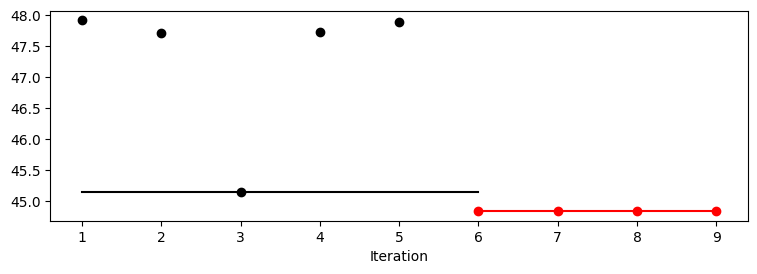

In [11]:
#| label: 601_plot_progress_1
spot_tuner.plot_progress()

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.

In [12]:
from spotpython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned                | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     3.0 |     4.0 | 4.0                  | transform_power_2_int |        76.96 | **      |
| epochs         | int    | 4         |     3.0 |     5.0 | 4.0                  | transform_power_2_int |         0.00 |         |
| batch_size     | int    | 4         |     1.0 |     5.0 | 2.0                  | transform_power_2_int |         0.00 |         |
| act_fn         | factor | ReLU      |     0.0 |     2.0 | LeakyReLU            | None                  |         0.00 |         |
| optimizer      | factor | SGD       |     0.0 |     2.0 | Adamax               | None                  |       100.00 | ***     |
| dropout_prob   | float  | 0.01      |     0.0 |   0.025 | 0.02202982420900

A histogram can be used to visualize the most important hyperparameters.

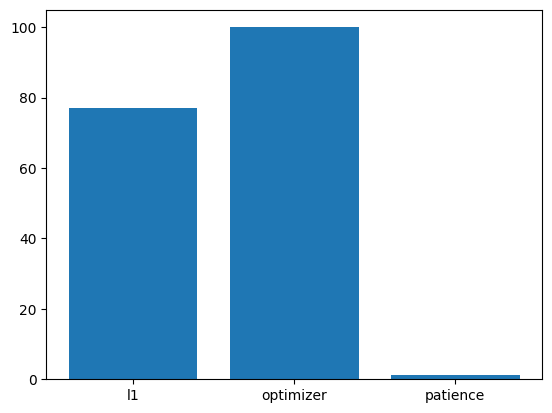

In [13]:
spot_tuner.plot_importance(threshold=1.0)

l1:  76.96490335348626
epochs:  0.001
batch_size:  0.001
act_fn:  0.001
optimizer:  100.0
dropout_prob:  0.001
lr_mult:  0.001
patience:  1.0916712523764185
initialization:  0.473750474202639


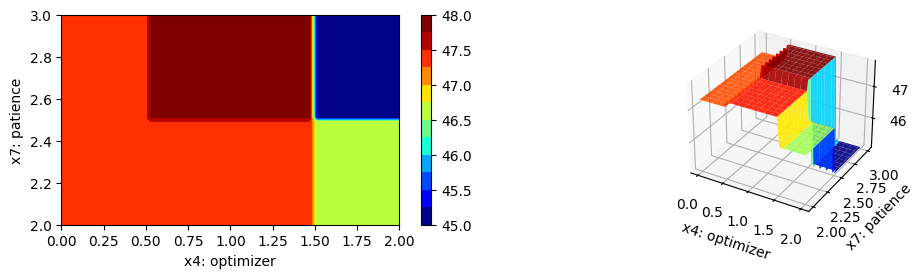

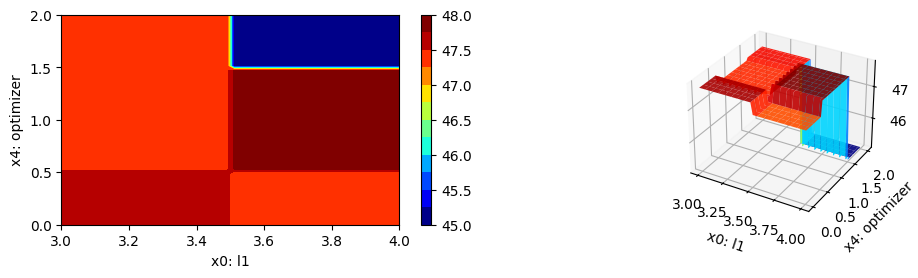

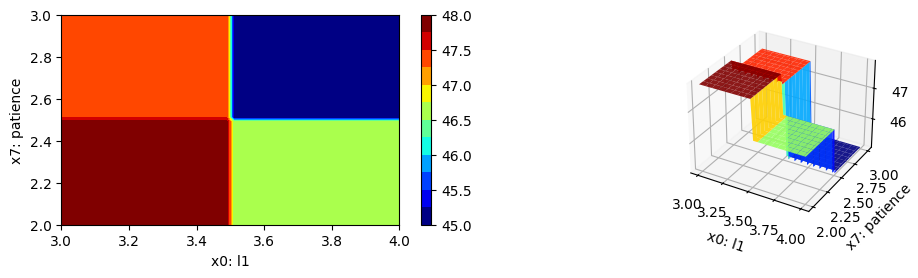

In [14]:
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

### Get the Tuned Architecture {#sec-get-spot-results-601}

In [15]:
import pprint
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': np.float64(0.022029824209003804),
 'epochs': 16,
 'initialization': 'xavier_normal',
 'l1': 16,
 'lr_mult': np.float64(7.654863226199673),
 'optimizer': 'Adamax',
 'patience': 8}
